In [2]:
import os

# Dataset root path
data_dir = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# List to store all file paths
all_files = []

# Walk through every folder and subfolder
for root, dirs, files in os.walk(data_dir):
    for f in files:
        file_path = os.path.join(root, f)
        all_files.append(file_path)

# Show total number of files
print(f"✅ Total files found: {len(all_files)}")

# Show a few sample file paths
print("\n📂 Example file paths:")
for i, path in enumerate(all_files[:15]):
    print(f"{i+1}. {path}")

# Optional: summary by folder (robust version)
folder_summary = {}
for f in all_files:
    relative_path = os.path.dirname(f).replace(data_dir, '').strip(os.sep)
    parts = relative_path.split(os.sep)
    folder = parts[0] if len(parts) > 0 and parts[0] != '' else "root"
    folder_summary[folder] = folder_summary.get(folder, 0) + 1

print("\n📊 File count by top-level folder:")
for k, v in folder_summary.items():
    print(f"{k:20s} : {v}")

✅ Total files found: 87204

📂 Example file paths:
1. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/SHA256SUMS.txt
2. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/RECORDS
3. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/example_physionet.py
4. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_v103_changelog.txt
5. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv
6. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv
7. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/LICENSE.txt
8. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publ

In [3]:
# === Step 0: Install required library ===
!pip install wfdb

# === Step 1: Import libraries ===
import os
import pandas as pd
import numpy as np
import wfdb
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

# === Step 2: Define ECG data loader ===
def load_raw_data(df, sampling_rate, path):
    """
    Load ECG signals from PTB-XL dataset.
    Returns a NumPy array of shape (n_samples, n_timesteps, n_leads)
    """
    file_col = 'filename_lr' if sampling_rate == 100 else 'filename_hr'
    data = [wfdb.rdsamp(os.path.join(path, f))[0] for f in df[file_col]]
    return np.array(data)

# === Step 3: Setup dataset path and sampling rate ===
path = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate = 100  # 100 Hz

# === Step 4: Load metadata and SCP codes ===
Y = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(lambda x: ast.literal_eval(x))

# === Step 5: Load ECG signal data ===
print("Loading ECG signal data...")
X = load_raw_data(Y, sampling_rate, path)
print(f"✅ Loaded {len(X)} ECG samples.")

# === Step 6: Load SCP statements and keep only diagnostic ones ===
agg_df = pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]  # keep only diagnostic statements

# === Step 7: Map SCP codes to diagnostic superclass ===
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)

# === Step 8: Keep only single-label ECGs ===
mask = Y['diagnostic_superclass'].apply(lambda x: len(x) == 1)
Y_filtered = Y[mask].copy()
X_filtered = X[mask.values]  # align signals

# === Step 9: Convert label list to string ===
Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].apply(lambda x: x[0])

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.20,   # 20% test
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

# Split 10% of the training set as validation
val_fraction = 0.10  # 10% of training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=val_fraction,
    random_state=42,
    stratify=y_train_full
)
# === Step 11: Encode labels ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# === Step 12: Convert to tensors for PyTorch ===
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(np.array(X_val), dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# === Step 13: Summary ===
print("\n✅ Split Summary:")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X_filtered):.2%})")
print(f"Validation: {len(X_val)} samples ({len(X_val)/len(X_filtered):.2%})")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(X_filtered):.2%})")

print("\n📊 Label distribution:")
print("Train:\n", pd.Series(y_train).value_counts(), "\n")
print("Validation:\n", pd.Series(y_val).value_counts(), "\n")
print("Test:\n", pd.Series(y_test).value_counts())

print("\n✅ Tensors ready for training:")
print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}, y_val: {y_val_tensor.shape}")
print(f"X_test: {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.8 MB/s eta 0:00:0000:01
Loading ECG signal data...
✅ Loaded 21799 ECG samples.

✅ Split Summary:
Train: 11695 samples (72.00%)
Validation: 1300 samples (8.00%)
Test: 3249 samples (20.00%)

📊 Label distribution:
Train:
 diagnostic_superclass
NORM    6529
MI      1823
STTC    1728
CD      1230
HYP      385
Name: count, dtype: int64 

Validation:
 diagnostic_superclass
NORM    726
MI      203
STTC    192
CD      136
HYP      43
Name: count, dtype: int64 

Test:
 diagnostic_superclass
NORM    1814
MI       506
STTC     480
CD       342
HYP      107
Name: count, dtype: int64

✅ Tensors ready for training:
X_train: torch.Size([11695, 1000, 12]), y_train: torch.Size([11695])
X_val: torch.Size([1300, 1000, 12]), y_val: torch.Size([1300])
X_test: torch.Size([3249, 1000, 12]), y_test: torch.Size([3249])


Using device: cuda


/tmp/ipykernel_47/1134691427.py:111: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_47/1134691427.py:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_47/1134691427.py:136: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/50 | Train: 0.0179 | Val: 0.0151 | Time: 17.1s
Epoch 2/50 | Train: 0.0153 | Val: 0.0148 | Time: 16.2s
Epoch 3/50 | Train: 0.0144 | Val: 0.0127 | Time: 16.2s
Epoch 4/50 | Train: 0.0139 | Val: 0.0133 | Time: 16.2s
Epoch 5/50 | Train: 0.0135 | Val: 0.0125 | Time: 16.2s
Epoch 6/50 | Train: 0.0126 | Val: 0.0124 | Time: 16.2s
Epoch 7/50 | Train: 0.0127 | Val: 0.0115 | Time: 16.2s
Epoch 8/50 | Train: 0.0119 | Val: 0.0114 | Time: 16.2s
Epoch 9/50 | Train: 0.0116 | Val: 0.0113 | Time: 16.2s
Epoch 10/50 | Train: 0.0114 | Val: 0.0113 | Time: 16.2s
Epoch 11/50 | Train: 0.0113 | Val: 0.0111 | Time: 16.3s
Epoch 12/50 | Train: 0.0119 | Val: 0.0107 | Time: 16.2s
Epoch 13/50 | Train: 0.0112 | Val: 0.0109 | Time: 16.2s
Epoch 14/50 | Train: 0.0106 | Val: 0.0104 | Time: 16.2s
Epoch 15/50 | Train: 0.0102 | Val: 0.0102 | Time: 16.3s
Epoch 16/50 | Train: 0.0105 | Val: 0.0100 | Time: 16.3s
Epoch 17/50 | Train: 0.0100 | Val: 0.0096 | Time: 16.2s
Epoch 18/50 | Train: 0.0098 | Val: 0.0102 | Time: 16.2s
E

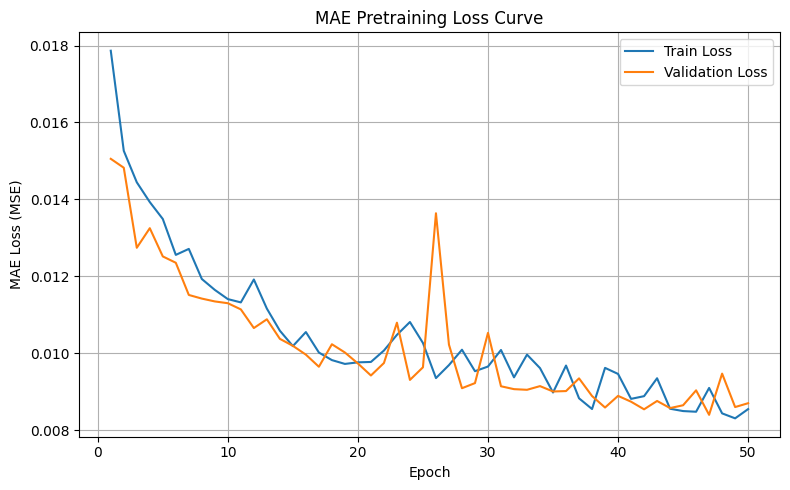

Saved checkpoints, loss curve, and CSV to mae_downstream


In [4]:
import os, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# ---------------- OUTPUT DIR ----------------
OUT_DIR = "mae_downstream"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- DATASET ----------------
class ECGDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

# ---------------- MAE MODEL ----------------
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + self.shortcut(x))

class ResNet1D(nn.Module):
    def __init__(self, in_channels=12):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv1d(in_channels, 64, 7, 2, 3, bias=False)
        self.bn1   = nn.BatchNorm1d(64)
        self.layer1 = self._make_layer(64,  2, 1)
        self.layer2 = self._make_layer(128, 2, 2)
        self.layer3 = self._make_layer(256, 2, 2)
        self.layer4 = self._make_layer(512, 2, 2)

    def _make_layer(self, planes, blocks, stride):
        layers = [BasicBlock1D(self.in_planes, planes, stride)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

class MAE_ResNet1D(nn.Module):
    def __init__(self, in_channels=12, mask_ratio=0.4):
        super().__init__()
        self.mask_ratio = mask_ratio
        self.encoder = ResNet1D(in_channels)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, in_channels, 3, padding=1)
        )

    def random_mask(self, x):
        B, C, L = x.shape
        num_mask = int(L * self.mask_ratio)
        mask = torch.ones(B, L, device=x.device)
        for i in range(B):
            idx = torch.randperm(L)[:num_mask]
            mask[i, idx] = 0
        return x * mask.unsqueeze(1), mask.unsqueeze(1)

    def forward(self, x):
        x_masked, mask = self.random_mask(x)
        z = self.encoder(x_masked)
        z = F.interpolate(z, size=x.shape[-1], mode="linear")
        x_rec = self.decoder(z)
        loss = F.mse_loss(x_rec * (1 - mask), x * (1 - mask))
        return loss

# ---------------- DATA ----------------
# X_train_tensor: torch.Tensor of shape (N, T, C)
# permute to (N, C, T) and optionally resize
X_mae = F.interpolate(X_train_tensor.permute(0,2,1), size=500, mode="linear").to(DEVICE)
from sklearn.model_selection import train_test_split
X_train_mae, X_val_mae = train_test_split(X_mae, test_size=0.1, random_state=42)

train_loader = DataLoader(ECGDataset(X_train_mae), batch_size=32, shuffle=True)
val_loader   = DataLoader(ECGDataset(X_val_mae), batch_size=32, shuffle=False)

# ---------------- TRAIN ----------------
model = MAE_ResNet1D(12, mask_ratio=0.4).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()

EPOCHS = 50
history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'epoch_time_s': []}

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = model(batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(DEVICE)
            with torch.cuda.amp.autocast():
                loss = model(batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    epoch_time = time.time() - t0

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['epoch_time_s'].append(epoch_time)

    print(f"Epoch {epoch}/{EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Time: {epoch_time:.1f}s")

    # ---------------- SAVE CHECKPOINT ----------------
    ckpt = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
    }
    torch.save(ckpt, os.path.join(OUT_DIR, f"mae_epoch_{epoch}.pth"))

# ---------------- SAVE LOSS CURVE ----------------
plt.figure(figsize=(8,5))
plt.plot(history['epoch'], history['train_loss'], label="Train Loss")
plt.plot(history['epoch'], history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MAE Loss (MSE)")
plt.title("MAE Pretraining Loss Curve")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "mae_loss_curve.png"), dpi=150)
plt.show()

# ---------------- SAVE HISTORY CSV ----------------
hist_df = pd.DataFrame(history)
hist_df.to_csv(os.path.join(OUT_DIR, "mae_loss_history.csv"), index=False)
print("Saved checkpoints, loss curve, and CSV to", OUT_DIR)


In [14]:
import os, joblib
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

OUT_DIR = "mae_downstream_ml"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- ML Dataset ----------------
class ECGDatasetFeat(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ---------------- Feature Extraction ----------------
# Use encoder from your in-memory pretrained MAE
encoder.eval()

def extract_features(X_tensor, batch_size=32):
    features = []
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size].to(DEVICE)
            feat = encoder(batch)
            if feat.dim() == 3:  # (B, C, L)
                feat = F.adaptive_avg_pool1d(feat, 1).squeeze(-1)
            features.append(feat.cpu())
    return torch.cat(features, dim=0).numpy()

# Convert (N, T, C) -> (N, C, T)
X_train_feat = extract_features(X_train_tensor.permute(0,2,1))
X_val_feat   = extract_features(X_val_tensor.permute(0,2,1))

# ---------------- Standardize Features ----------------
scaler = StandardScaler()
X_train_feat = scaler.fit_transform(X_train_feat)
X_val_feat   = scaler.transform(X_val_feat)

joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))
# ---------------- ML Classifiers ----------------
classifiers = {
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    # Increase max_iter and use solver='saga' to avoid convergence warning
    "LogisticRegression": LogisticRegression(max_iter=5000, solver='saga')
}

summary_rows = []

y_train_np = y_train_tensor.cpu().numpy()
y_val_np   = y_val_tensor.cpu().numpy()

for name, clf in classifiers.items():
    clf.fit(X_train_feat, y_train_np)
    y_pred = clf.predict(X_val_feat)
    acc = accuracy_score(y_val_np, y_pred)
    report_df = pd.DataFrame(classification_report(y_val_np, y_pred, output_dict=True)).transpose()

    # Save model & classification report
    joblib.dump(clf, os.path.join(OUT_DIR, f"{name}_model.joblib"))
    report_df.to_csv(os.path.join(OUT_DIR, f"{name}_classification_report.csv"))

    summary_rows.append({
        "model": name,
        "accuracy": acc,
        "train_samples": X_train_feat.shape[0],
        "val_samples": X_val_feat.shape[0]
    })
    print(f"{name} Accuracy: {acc:.4f}")
    print("-"*60)

# Save summary CSV
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(os.path.join(OUT_DIR, "ml_downstream_summary.csv"), index=False)
print("Saved models, classification reports, and summary CSV to", OUT_DIR)



Using device: cuda
DecisionTree Accuracy: 0.4923
------------------------------------------------------------
RandomForest Accuracy: 0.6362
------------------------------------------------------------
SVM Accuracy: 0.7062
------------------------------------------------------------
LogisticRegression Accuracy: 0.7177
------------------------------------------------------------
Saved models, classification reports, and summary CSV to mae_downstream_ml


In [16]:
import pandas as pd
import os

OUT_DIR = "mae_downstream_ml"

for model_name in ["DecisionTree", "RandomForest", "SVM", "LogisticRegression"]:
    report_path = os.path.join(OUT_DIR, f"{model_name}_classification_report.csv")
    if os.path.exists(report_path):
        print(f"\n=== {model_name} Classification Report ===")
        report_df = pd.read_csv(report_path, index_col=0)
        print(report_df)
    else:
        print(f"{model_name} report not found.")



=== DecisionTree Classification Report ===
              precision    recall  f1-score      support
0              0.284615  0.272059  0.278195   136.000000
1              0.075472  0.093023  0.083333    43.000000
2              0.272727  0.295567  0.283688   203.000000
3              0.703919  0.668044  0.685512   726.000000
4              0.259615  0.281250  0.270000   192.000000
accuracy       0.492308  0.492308  0.492308     0.492308
macro avg      0.319270  0.321989  0.320146  1300.000000
weighted avg   0.506314  0.492308  0.498868  1300.000000

=== RandomForest Classification Report ===
              precision    recall  f1-score      support
0              0.765957  0.264706  0.393443   136.000000
1              0.333333  0.046512  0.081633    43.000000
2              0.722892  0.295567  0.419580   203.000000
3              0.630728  0.966942  0.763458   726.000000
4              0.529412  0.140625  0.222222   192.000000
accuracy       0.636154  0.636154  0.636154     0.636154


Feature shape: (11695, 512)


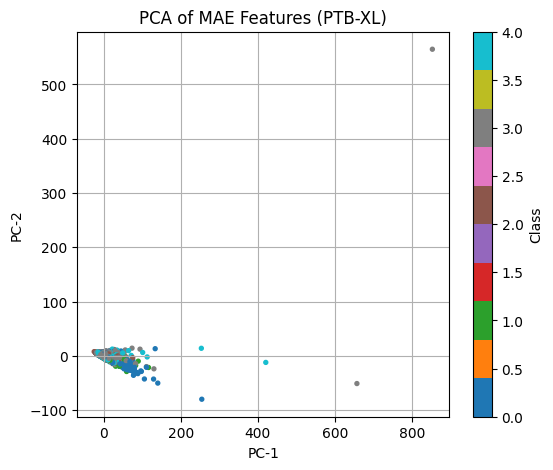

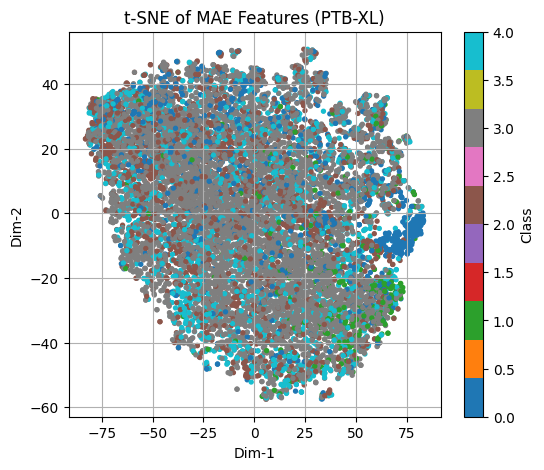

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

X_feat = X_train_feat
y_feat = y_train_tensor.cpu().numpy()

print("Feature shape:", X_feat.shape)

# ---------- PCA (2D) ----------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_feat)

plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y_feat,
    cmap="tab10",
    s=8
)
plt.title("PCA of MAE Features (PTB-XL)")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.colorbar(scatter, label="Class")  # Fixed syntax here
plt.grid(True)
plt.show()

# ---------- PCA -> t-SNE ----------
pca_50 = PCA(n_components=50, random_state=42)
X_pca_50 = pca_50.fit_transform(X_feat)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)
X_tsne = tsne.fit_transform(X_pca_50)

plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_tsne[:,0],
    X_tsne[:,1],
    c=y_feat,
    cmap="tab10",
    s=8
)
plt.title("t-SNE of MAE Features (PTB-XL)")  # Moved outside the scatter line
plt.xlabel("Dim-1")
plt.ylabel("Dim-2")
plt.colorbar(scatter, label="Class")
plt.grid(True)
plt.show()
